# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Mapping Analysis

Mark Bauer

# Goal
In this notebook, we analyze NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to answer the following questions:

- What is the distribution of street flooding complaints by neighborhood?
- How have street flooding complaints changed over time?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

[geoplot](https://residentmario.github.io/geoplot/index.html#) is a high-level Python geospatial plotting library. It’s an extension to cartopy and matplotlib which makes mapping easy: like seaborn for geospatial.

[fiona](https://github.com/Toblerity/Fiona) is a geospatial library that reads and writes geographical data files.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

Table of Contents
=================

   1. Importing Libraries
   2. Loading Data
   3. Data Inspection
       - 3.1 Basic Data Inspection
       - 3.2 Calculating Summary Statistics
       - 3.3 Identifying Null Values
   4. Data Wrangling
       - 4.1 Converting date column to Python's datetime64[ns] data type
       - 4.2 Dropping null values in our x, y coordinate columns
       - 4.3 Creating a GeoDataframe from x,y coordinates
   5. Mapping
       - 5.1 Citywide
       - 5.2 By Borough
       - 5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)
   6. Timedelta of Complaints 

# 1. Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy            : 1.23.1
pandas           : 1.4.3
geopandas        : 0.11.1
geoplot          : 0.5.1
fiona            : 1.8.21
matplotlib.pyplot: unknown
seaborn          : 0.11.2



Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [4]:
# list items in data folder
%ls data/

README.md                       street-flooding-complaints.csv
data-dictionaries/              streets-clipped.json


In [5]:
# read data as a dataframe
df = pd.read_csv('data/street-flooding-complaints.csv', low_memory=False)

# previewing first five rows in data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (27902, 34)


unique_key             created_date agency  \
0    48542220  2020-12-31T15:41:00.000    DEP   
1    48536430  2020-12-31T14:49:00.000    DEP   
2    48539361  2020-12-31T14:03:00.000    DEP   
3    48543132  2020-12-31T13:48:00.000    DEP   
4    48536441  2020-12-31T13:10:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip      incident_address      street_name  \
0  Street Flooding (SJ)       11420.0     117-17 135 STREET       135 STREET   
1  Street Flooding (SJ)       11357.0      20-24 150 STREET       150 STREET   
2  Street Flooding (SJ)       11228.0         7223 8 AVENUE         8 AVENUE   
3  Street Flooding (SJ)       10032.0                   NaN              NaN   
4  Street Flooding (SJ)       11234.0  3123 FILLMORE AVENUE  FILLMORE AVENUE   

  cross_street_1  ...                                           location  \
0      FOCH BLVD  ...  {'latitude': '40.67703755925495', 'longitude':...   
1         20 AVE  ...  {'latitude': '40.78072630540092', 'longitude':...   
2          72 ST  ...  {'latitude': '40.62849640806448', 'longitude':...   
3            NaN  ...  {'latitude': '40.841051689545516', 'longitude'...   
4        E 31 ST  ...  {'latitude': '40.609203447399906', 'longitude'...   

  intersection_street_1 intersection_street_2              closed_date  \
0                   NaN                   NaN  2021-01-01T00:20:00.000   
1                   NaN                   NaN  2021-01-04T10:15:00.000   
2                   NaN                   NaN  2021-01-02T11:25:00.000   
3       RIVERSIDE DRIVE      WEST  165 STREET  2020-12-31T14:50:00.000   
4                   NaN                   NaN  2021-01-03T10:45:00.000   

                              resolution_description  \
0  Please call 311 for further information. If yo...   
1  The Department of Environment Protection inspe...   
2  The Department of Environmental Protection has...   
3  Please call 311 for further information. If yo...   
4  The Department of Environmental Protection ins...   

   resolution_action_updated_date location_type  landmark  facility_type  \
0         2021-01-01T00:20:00.000           NaN       NaN            NaN   
1         2021-01-04T10:15:00.000           NaN       NaN            NaN   
2         2021-01-02T11:25:00.000           NaN       NaN            NaN   
3         2020-12-31T14:50:00.000           NaN       NaN            NaN   
4         2021-01-03T10:45:00.000           NaN       NaN            NaN   

  due_date  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  

[5 rows x 34 columns]

In [6]:
# printing the column names, non-null counts, and data types of our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27902 non-null  int64  
 1   created_date                    27902 non-null  object 
 2   agency                          27902 non-null  object 
 3   agency_name                     27902 non-null  object 
 4   complaint_type                  27902 non-null  object 
 5   descriptor                      27902 non-null  object 
 6   incident_zip                    27045 non-null  float64
 7   incident_address                17865 non-null  object 
 8   street_name                     17865 non-null  object 
 9   cross_street_1                  24148 non-null  object 
 10  cross_street_2                  24137 non-null  object 
 11  address_type                    27896 non-null  object 
 12  city                            

In [7]:
# printing the columns of our dataframe
df.columns

Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'incident_zip', 'incident_address', 'street_name',
       'cross_street_1', 'cross_street_2', 'address_type', 'city', 'status',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'intersection_street_1', 'intersection_street_2',
       'closed_date', 'resolution_description',
       'resolution_action_updated_date', 'location_type', 'landmark',
       'facility_type', 'due_date'],
      dtype='object')

In [8]:
df = df[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27902 non-null  int64  
 1   created_date                    27902 non-null  object 
 2   closed_date                     27900 non-null  object 
 3   agency                          27902 non-null  object 
 4   agency_name                     27902 non-null  object 
 5   complaint_type                  27902 non-null  object 
 6   descriptor                      27902 non-null  object 
 7   incident_zip                    27045 non-null  float64
 8   intersection_street_1           10091 non-null  object 
 9   intersection_street_2           10091 non-null  object 
 10  address_type                    27896 non-null  object 
 11  city                            27048 non-null  object 
 12  status                          

In [9]:
# printing True/False if column is unique on our unique key (DOITT_ID)
df['unique_key'].is_unique

True

In [10]:
df['descriptor'].value_counts()

Street Flooding (SJ)    27902
Name: descriptor, dtype: int64

In [11]:
print(('This dataset is from {} to {}'.format(df.created_date.min()[0:10], 
                                              df.created_date.max()[0:10])))

This dataset is from 2010-01-02 to 2020-12-31


In [12]:
# printing descriptive statistics of our numeric columns in our data
df.describe()

unique_key  incident_zip  x_coordinate_state_plane  \
count  2.790200e+04  27045.000000              2.695900e+04   
mean   3.243189e+07  10969.151488              1.005498e+06   
std    9.183919e+06    536.262125              3.505257e+04   
min    1.563993e+07  10001.000000              9.133570e+05   
25%    2.429024e+07  10312.000000              9.868870e+05   
50%    3.276295e+07  11220.000000              1.007480e+06   
75%    4.039421e+07  11385.000000              1.033980e+06   
max    4.854313e+07  11697.000000              1.067279e+06   

       y_coordinate_state_plane      latitude     longitude           bbl  
count              26959.000000  26959.000000  26959.000000  1.615900e+04  
mean              186184.607441     40.677615    -73.923323  3.699429e+09  
std                30576.150750      0.083924      0.126329  1.075864e+09  
min               121032.000000     40.498628    -74.254937  0.000000e+00  
25%               161248.000000     40.609123    -73.990504  3.060255e+09  
50%               183618.000000     40.670610    -73.916267  4.067910e+09  
75%               206488.500000     40.733373    -73.820554  4.156250e+09  
max               271876.000000     40.912869    -73.700384  5.080500e+09

In [13]:
df.describe(include=['O']).T

count unique  \
created_date                    27902  26389   
closed_date                     27900  25420   
agency                          27902      1   
agency_name                     27902      1   
complaint_type                  27902      1   
descriptor                      27902      1   
intersection_street_1           10091   2844   
intersection_street_2           10091   2854   
address_type                    27896      4   
city                            27048     87   
status                          27902      4   
resolution_description          27896     61   
resolution_action_updated_date  27902  25410   
community_board                 27900     73   
borough                         27900      6   
open_data_channel_type          27902      5   
park_facility_name              27902      1   
park_borough                    27900      6   
location                        26959  17040   
incident_address                17865  12445   
street_name                     17865   4108   
cross_street_1                  24148   4621   
cross_street_2                  24137   4698   

                                                                              top  \
created_date                                              2011-08-28T00:00:00.000   
closed_date                                               2017-05-06T08:30:00.000   
agency                                                                        DEP   
agency_name                                Department of Environmental Protection   
complaint_type                                                              Sewer   
descriptor                                                   Street Flooding (SJ)   
intersection_street_1                                                    BROADWAY   
intersection_street_2                                                    BROADWAY   
address_type                                                              ADDRESS   
city                                                                     BROOKLYN   
status                                                                     Closed   
resolution_description          The Department of Environment Protection inspe...   
resolution_action_updated_date                            2017-05-06T08:30:00.000   
community_board                                                  02 STATEN ISLAND   
borough                                                                    QUEENS   
open_data_channel_type                                                      PHONE   
park_facility_name                                                    Unspecified   
park_borough                                                               QUEENS   
location                        {'latitude': '40.67637306593017', 'longitude':...   
incident_address                                   133-25 FRANCIS LEWIS BOULEVARD   
street_name                                                              BROADWAY   
cross_street_1                                                               BEND   
cross_street_2                                                           DEAD END   

                                 freq  
created_date                       13  
closed_date                        36  
agency                          27902  
agency_name                     27902  
complaint_type                  27902  
descriptor                      27902  
intersection_street_1              98  
intersection_street_2             169  
address_type                    16733  
city                             6978  
status                          27891  
resolution_description          10327  
resolution_action_updated_date     36  
community_board                  2080  
borough                         11039  
open_data_channel_type          16285  
park_facility_name              27902  
park_borough                    11039  
location                           59  
incident_address                   59 

## 3.3 Identifying Null/NA Values

In [14]:
print('Sum of nulls in column:')
df.isnull().sum().sort_values(ascending=False)

Sum of nulls in column:


intersection_street_1             17811
intersection_street_2             17811
bbl                               11743
street_name                       10037
incident_address                  10037
cross_street_2                     3765
cross_street_1                     3754
location                            943
x_coordinate_state_plane            943
longitude                           943
latitude                            943
y_coordinate_state_plane            943
incident_zip                        857
city                                854
address_type                          6
resolution_description                6
park_borough                          2
community_board                       2
borough                               2
closed_date                           2
open_data_channel_type                0
park_facility_name                    0
created_date                          0
resolution_action_updated_date        0
status                                0


In [15]:
print('Sum of nulls in all columns: {:,}'.format(df.isnull().sum().sum()))

Sum of nulls in all columns: 81,404


# 4. Data Wrangling

## 4.2 Dropping null values in our x, y coordinate columns

In [16]:
df[['x_coordinate_state_plane', 'y_coordinate_state_plane']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x_coordinate_state_plane  26959 non-null  float64
 1   y_coordinate_state_plane  26959 non-null  float64
dtypes: float64(2)
memory usage: 436.1 KB


In [17]:
print('Count of nulls:')
df[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isnull().sum()

Count of nulls:


x_coordinate_state_plane    943
y_coordinate_state_plane    943
dtype: int64

In [18]:
print('% of nulls:')
df[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isnull().sum() / len(df) * 100

% of nulls:


x_coordinate_state_plane    3.379686
y_coordinate_state_plane    3.379686
dtype: float64

## 4.3 Creating a GeoDataframe from x,y coordinates

In [19]:
print('Dropping nulls in the x, y coordinate columns and creating a geodataframe.')

to_points = df.loc[df['x_coordinate_state_plane'].notnull()]
gdf = gpd.GeoDataFrame(to_points, 
                       geometry=gpd.points_from_xy(to_points['x_coordinate_state_plane'], 
                                                   to_points['y_coordinate_state_plane']))

gdf.head()

Dropping nulls in the x, y coordinate columns and creating a geodataframe.


unique_key             created_date              closed_date agency  \
0    48542220  2020-12-31T15:41:00.000  2021-01-01T00:20:00.000    DEP   
1    48536430  2020-12-31T14:49:00.000  2021-01-04T10:15:00.000    DEP   
2    48539361  2020-12-31T14:03:00.000  2021-01-02T11:25:00.000    DEP   
3    48543132  2020-12-31T13:48:00.000  2020-12-31T14:50:00.000    DEP   
4    48536441  2020-12-31T13:10:00.000  2021-01-03T10:45:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11357.0                   NaN   
2  Street Flooding (SJ)       11228.0                   NaN   
3  Street Flooding (SJ)       10032.0       RIVERSIDE DRIVE   
4  Street Flooding (SJ)       11234.0                   NaN   

  intersection_street_2  ... park_borough   latitude  longitude  \
0                   NaN  ...       QUEENS  40.677038 -73.804417   
1                   NaN  ...       QUEENS  40.780726 -73.814288   
2                   NaN  ...     BROOKLYN  40.628496 -74.016810   
3      WEST  165 STREET  ...    MANHATTAN  40.841052 -73.944679   
4                   NaN  ...     BROOKLYN  40.609203 -73.936548   

                                            location      incident_address  \
0  {'latitude': '40.67703755925495', 'longitude':...     117-17 135 STREET   
1  {'latitude': '40.78072630540092', 'longitude':...      20-24 150 STREET   
2  {'latitude': '40.62849640806448', 'longitude':...         7223 8 AVENUE   
3  {'latitude': '40.841051689545516', 'longitude'...                   NaN   
4  {'latitude': '40.609203447399906', 'longitude'...  3123 FILLMORE AVENUE   

       street_name cross_street_1  cross_street_2           bbl  \
0       135 STREET      FOCH BLVD         120 AVE  4.116990e+09   
1       150 STREET         20 AVE           20 RD  4.046700e+09   
2         8 AVENUE          72 ST           7 AVE  3.059120e+09   
3              NaN            NaN             NaN           NaN   
4  FILLMORE AVENUE        E 31 ST         E 32 ST  3.084750e+09   

                         geometry  
0  POINT (1038500.000 186000.000)  
1  POINT (1035682.000 223771.000)  
2   POINT (979584.000 168255.000)  
3   POINT (999557.000 245700.000)  
4  POINT (1001868.000 161232.000)  

[5 rows x 31 columns]

In [20]:
print('Our new dataframe contains {:,} rows.'.format(len(gdf)))
total = (len(df) - len(gdf))
percent = round((1 - len(gdf)/len(df)) * 100, 2)

print("We've dropped {} rows or {}% of our data for mapping purposes.".format(total, percent))

Our new dataframe contains 26,959 rows.
We've dropped 943 rows or 3.38% of our data for mapping purposes.


In [21]:
gdf[['geometry']].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26959 entries, 0 to 27901
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  26959 non-null  geometry
dtypes: geometry(1)
memory usage: 421.2 KB


In [22]:
print('Nulls in our x, y coordinate columns:')
gdf[['x_coordinate_state_plane', 'y_coordinate_state_plane', 'geometry']].isnull().sum()

Nulls in our x, y coordinate columns:


x_coordinate_state_plane    0
y_coordinate_state_plane    0
geometry                    0
dtype: int64

## 4.1 Converting date column to Python's datetime64[ns] data type

In [23]:
gdf['created_date'] = pd.to_datetime(gdf['created_date'])
gdf['year'] = gdf['created_date'].dt.year

gdf[['created_date']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26959 entries, 0 to 27901
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_date  26959 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 421.2 KB


In [24]:
print('Summary statistics on our date column.')
gdf[['created_date', 'year']].describe(datetime_is_numeric=True)

Summary statistics on our date column.


created_date          year
count                          26959  26959.000000
mean   2015-11-07 13:32:24.012018176   2015.348455
min              2010-01-02 08:26:00   2010.000000
25%              2012-12-08 00:17:30   2012.000000
50%              2016-03-15 07:08:00   2016.000000
75%              2018-10-02 13:58:00   2018.000000
max              2020-12-31 15:41:00   2020.000000
std                              NaN      3.216561

# 5. Mapping

In [25]:
print(type(gdf))
gdf = gdf.set_crs(epsg=2263)

gdf.crs

<class 'geopandas.geodataframe.GeoDataFrame'>


<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

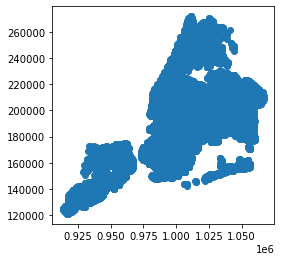

In [26]:
gdf.plot()

In [27]:
# read in nta shapefile
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_shape = gpd.read_file(url)

print('shape of data: {}'.format(len(nta_shape)))
nta_shape.head()

shape of data: 195


ntacode     shape_area county_fips                ntaname     shape_leng  \
0    QN08  77412747.7931         081             St. Albans  45401.3169214   
1    BX28  25666124.5948         005  Van Cortlandt Village   21945.719299   
2    QN55  82461393.7722         081       South Ozone Park   36708.169488   
3    BK40  14041667.9508         047        Windsor Terrace  19033.6718103   
4    BK50  82089678.5909         047               Canarsie  43703.6095503   

  boro_name boro_code                                           geometry  
0    Queens         4  MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...  
1     Bronx         2  MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ...  
2    Queens         4  MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ...  
3  Brooklyn         3  MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ...  
4  Brooklyn         3  MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...

In [28]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


In [29]:
nta_shape = nta_shape.to_crs(epsg=2263)
nta_shape.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

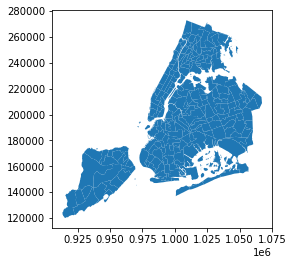

In [30]:
nta_shape.plot()

## 5.1 City-wide 

30 hexagons in the x-direction

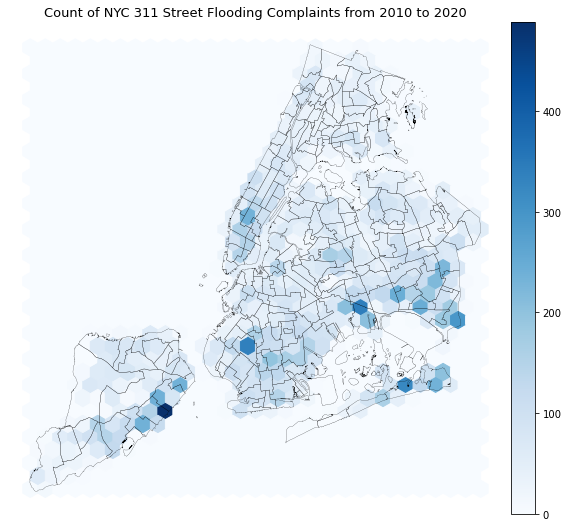

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf['x_coordinate_state_plane'], 
               gdf['y_coordinate_state_plane'], 
               gridsize=30, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.plot(facecolor="none", 
               edgecolor="black", 
               linewidth=.2,
               ax=ax)

ax.set_title("Count of NYC 311 Street Flooding Complaints from 2010 to 2020", fontsize=13)
ax.axis('off')
plt.tight_layout()

50 hexagons in the x-direction

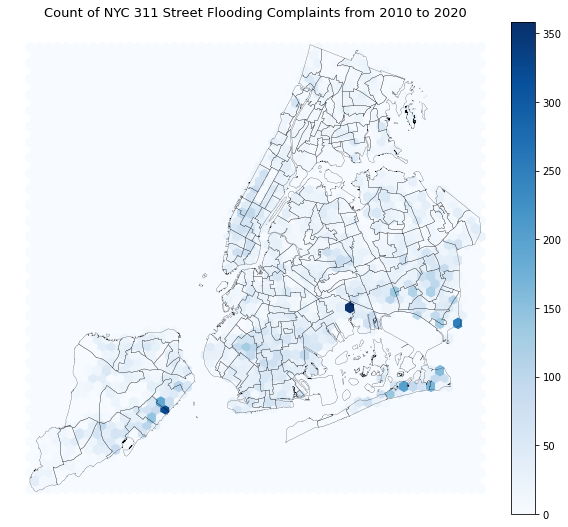

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf['x_coordinate_state_plane'], 
               gdf['y_coordinate_state_plane'], 
               gridsize=50, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.plot(facecolor="none", 
               edgecolor="black", 
               linewidth=.2,
               ax=ax)

ax.set_title("Count of NYC 311 Street Flooding Complaints from 2010 to 2020", fontsize=13)
ax.axis('off')
plt.tight_layout()

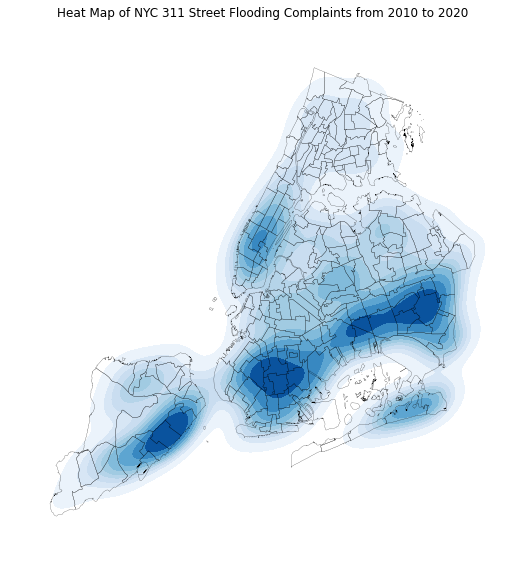

In [33]:
ax = geoplot.kdeplot(df=gdf.to_crs(4326),
                     shade=True, 
                     cmap='Blues',
                     projection=geoplot.crs.AlbersEqualArea(), 
                     figsize=(8, 8))

geoplot.polyplot(df=nta_shape.to_crs(4326), 
                 ax=ax, 
                 linewidth=.2,
                 zorder=1)

ax.set_title('Heat Map of NYC 311 Street Flooding Complaints from 2010 to 2020', fontsize=12)
plt.tight_layout()

# Spatial Join Points to Neighborhoods

In [34]:
gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [35]:
nta_shape.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [36]:
gdf_with_nta = (
    gpd
    .sjoin(gdf,
           nta_shape, 
           how="inner", 
           predicate='within')
    .reset_index(drop=True)
)

gdf_with_nta.head()

unique_key        created_date              closed_date agency  \
0    48542220 2020-12-31 15:41:00  2021-01-01T00:20:00.000    DEP   
1    48540279 2020-12-31 09:23:00  2021-01-05T10:15:00.000    DEP   
2    48534652 2020-12-30 17:09:00  2020-12-31T07:02:00.000    DEP   
3    48496821 2020-12-26 16:23:00  2020-12-28T09:45:00.000    DEP   
4    48367735 2020-12-09 12:57:00  2020-12-09T17:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ...                        geometry  year  \
0                   NaN  ...  POINT (1038500.000 186000.000)  2020   
1                   NaN  ...  POINT (1031154.000 187736.000)  2020   
2                   NaN  ...  POINT (1035567.000 186465.000)  2020   
3                   NaN  ...  POINT (1037333.000 184337.000)  2020   
4                   NaN  ...  POINT (1036537.000 188991.000)  2020   

  index_right ntacode     shape_area county_fips           ntaname  \
0           2    QN55  82461393.7722         081  South Ozone Park   
1           2    QN55  82461393.7722         081  South Ozone Park   
2           2    QN55  82461393.7722         081  South Ozone Park   
3           2    QN55  82461393.7722         081  South Ozone Park   
4           2    QN55  82461393.7722         081  South Ozone Park   

     shape_leng  boro_name boro_code  
0  36708.169488     Queens         4  
1  36708.169488     Queens         4  
2  36708.169488     Queens         4  
3  36708.169488     Queens         4  
4  36708.169488     Queens         4  

[5 rows x 40 columns]

In [37]:
print('Our new dataframe contains {:,} rows.'.format(len(gdf_with_nta)))

total = len(gdf) - len(gdf_with_nta)
percent = round((1 - len(gdf_with_nta)/len(gdf)) * 100, 2)

print("We've dropped {} rows or {}% of our data not within a neighorbood.".format(total, percent))

Our new dataframe contains 26,956 rows.
We've dropped 3 rows or 0.01% of our data not within a neighorbood.


In [38]:
print('our unique_key column unique: {}.'.format(gdf_with_nta['unique_key'].is_unique))

our unique_key column unique: True.


In [39]:
gdf_with_nta.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'geometry', 'year', 'index_right', 'ntacode',
       'shape_area', 'county_fips', 'ntaname', 'shape_leng', 'boro_name',
       'boro_code'],
      dtype='object')

In [40]:
gdf_with_nta = gdf_with_nta[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'geometry', 'year', 'ntacode', 'county_fips', 'ntaname', 'boro_name',
       'boro_code']]

gdf_with_nta.head()

unique_key        created_date              closed_date agency  \
0    48542220 2020-12-31 15:41:00  2021-01-01T00:20:00.000    DEP   
1    48540279 2020-12-31 09:23:00  2021-01-05T10:15:00.000    DEP   
2    48534652 2020-12-30 17:09:00  2020-12-31T07:02:00.000    DEP   
3    48496821 2020-12-26 16:23:00  2020-12-28T09:45:00.000    DEP   
4    48367735 2020-12-09 12:57:00  2020-12-09T17:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                   NaN  ...      FOCH BLVD        120 AVE  4.116990e+09   
1                   NaN  ...        107 AVE        109 AVE  4.095470e+09   
2                   NaN  ...         124 ST         125 ST  4.116510e+09   
3                   NaN  ...      CEDRIC RD     SUTTER AVE           NaN   
4                   NaN  ...        109 AVE        111 AVE  4.116110e+09   

                         geometry  year ntacode county_fips           ntaname  \
0  POINT (1038500.000 186000.000)  2020    QN55         081  South Ozone Park   
1  POINT (1031154.000 187736.000)  2020    QN55         081  South Ozone Park   
2  POINT (1035567.000 186465.000)  2020    QN55         081  South Ozone Park   
3  POINT (1037333.000 184337.000)  2020    QN55         081  South Ozone Park   
4  POINT (1036537.000 188991.000)  2020    QN55         081  South Ozone Park   

   boro_name boro_code  
0     Queens         4  
1     Queens         4  
2     Queens         4  
3     Queens         4  
4     Queens         4  

[5 rows x 37 columns]

checking borough comparison between complaint and nta

In [41]:
gdf_with_nta[['borough', 'boro_name']]

borough      boro_name
0             QUEENS         Queens
1             QUEENS         Queens
2             QUEENS         Queens
3             QUEENS         Queens
4             QUEENS         Queens
...              ...            ...
26951  STATEN ISLAND  Staten Island
26952  STATEN ISLAND  Staten Island
26953  STATEN ISLAND  Staten Island
26954  STATEN ISLAND  Staten Island
26955  STATEN ISLAND  Staten Island

[26956 rows x 2 columns]

In [42]:
gdf_with_nta['borough'] = gdf_with_nta['borough'].str.title()

(gdf_with_nta
 .loc[gdf_with_nta['borough'] != gdf_with_nta['boro_name']]
 .loc[:, ['borough', 'boro_name']]
)

borough  boro_name
4589        Queens   Brooklyn
4643   Unspecified   Brooklyn
4666        Queens   Brooklyn
4681        Queens   Brooklyn
4697        Queens   Brooklyn
...            ...        ...
24810        Bronx  Manhattan
24811        Bronx  Manhattan
24812        Bronx  Manhattan
24821        Bronx  Manhattan
24827        Bronx  Manhattan

[102 rows x 2 columns]

In [43]:
# dropping the borough column from the 311 dataset
gdf_with_nta = gdf_with_nta.drop(columns=['borough'])

gdf_with_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26956 entries, 0 to 26955
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      26956 non-null  int64         
 1   created_date                    26956 non-null  datetime64[ns]
 2   closed_date                     26954 non-null  object        
 3   agency                          26956 non-null  object        
 4   agency_name                     26956 non-null  object        
 5   complaint_type                  26956 non-null  object        
 6   descriptor                      26956 non-null  object        
 7   incident_zip                    26956 non-null  float64       
 8   intersection_street_1           9350 non-null   object        
 9   intersection_street_2           9350 non-null   object        
 10  address_type                    26956 non-null  object        

In [44]:
gdf_with_nta['boro_name'].value_counts(dropna=False)

Queens           10631
Brooklyn          6946
Staten Island     4928
Manhattan         2552
Bronx             1899
Name: boro_name, dtype: int64

In [45]:
gdf_with_nta['ntaname'].value_counts(dropna=False).head(20)

New Dorp-Midland Beach                                   763
Hammels-Arverne-Edgemere                                 696
Lindenwood-Howard Beach                                  605
St. Albans                                               581
Far Rockaway-Bayswater                                   541
Borough Park                                             535
Old Town-Dongan Hills-South Beach                        523
Great Kills                                              515
Rosedale                                                 457
East New York                                            424
Canarsie                                                 423
South Ozone Park                                         419
Springfield Gardens South-Brookville                     415
New Springville-Bloomfield-Travis                        413
Oakwood-Oakwood Beach                                    408
Georgetown-Marine Park-Bergen Beach-Mill Basin           397
Breezy Point-Belle Harbo

In [46]:
gdf_with_nta['city'].value_counts(dropna=False).head(20)

BROOKLYN               6944
STATEN ISLAND          4928
NEW YORK               2517
BRONX                  1934
Jamaica                1202
Far Rockaway            911
Flushing                602
Rosedale                530
Howard Beach            502
Springfield Gardens     429
Queens Village          369
Saint Albans            362
Arverne                 336
Ridgewood               292
South Ozone Park        264
Rockaway Park           258
Middle Village          256
Astoria                 242
Ozone Park              238
Bayside                 191
Name: city, dtype: int64

In [47]:
#make a copy of the dataframe, I prefer the gdf naming convention
gdf = gdf_with_nta.copy()

gdf.head()

unique_key        created_date              closed_date agency  \
0    48542220 2020-12-31 15:41:00  2021-01-01T00:20:00.000    DEP   
1    48540279 2020-12-31 09:23:00  2021-01-05T10:15:00.000    DEP   
2    48534652 2020-12-30 17:09:00  2020-12-31T07:02:00.000    DEP   
3    48496821 2020-12-26 16:23:00  2020-12-28T09:45:00.000    DEP   
4    48367735 2020-12-09 12:57:00  2020-12-09T17:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                   NaN  ...      FOCH BLVD        120 AVE  4.116990e+09   
1                   NaN  ...        107 AVE        109 AVE  4.095470e+09   
2                   NaN  ...         124 ST         125 ST  4.116510e+09   
3                   NaN  ...      CEDRIC RD     SUTTER AVE           NaN   
4                   NaN  ...        109 AVE        111 AVE  4.116110e+09   

                         geometry  year ntacode  county_fips  \
0  POINT (1038500.000 186000.000)  2020    QN55          081   
1  POINT (1031154.000 187736.000)  2020    QN55          081   
2  POINT (1035567.000 186465.000)  2020    QN55          081   
3  POINT (1037333.000 184337.000)  2020    QN55          081   
4  POINT (1036537.000 188991.000)  2020    QN55          081   

            ntaname boro_name boro_code  
0  South Ozone Park    Queens         4  
1  South Ozone Park    Queens         4  
2  South Ozone Park    Queens         4  
3  South Ozone Park    Queens         4  
4  South Ozone Park    Queens         4  

[5 rows x 36 columns]

# Neighborhood Tabulation Areas Analysis

In [48]:
# group complaints by NTA
grouped_gdf = (
    gdf
    .groupby(by='ntaname')['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

grouped_gdf.sort_values(by='count', ascending=False).head()

ntaname  count
116    New Dorp-Midland Beach    763
80   Hammels-Arverne-Edgemere    696
97    Lindenwood-Howard Beach    605
157                St. Albans    581
61     Far Rockaway-Bayswater    541

In [49]:
# sanity check that groupby counts reconcile
print('row count: {:,}'.format(len(gdf)))
print('grouped count: {:,}'.format(grouped_gdf['count'].sum()))

row count: 26,956
grouped count: 26,956


In [50]:
grouped_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ntaname  194 non-null    object
 1   count    194 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [51]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


In [52]:
# merge groupby complaint counts with nta shapefile
nta_shp_counts = nta_shape.merge(grouped_gdf, 
                                 left_on='ntaname', 
                                 right_on='ntaname')

nta_shp_counts.head()

ntacode     shape_area county_fips                ntaname     shape_leng  \
0    QN08  77412747.7931         081             St. Albans  45401.3169214   
1    BX28  25666124.5948         005  Van Cortlandt Village   21945.719299   
2    QN55  82461393.7722         081       South Ozone Park   36708.169488   
3    BK40  14041667.9508         047        Windsor Terrace  19033.6718103   
4    BK50  82089678.5909         047               Canarsie  43703.6095503   

  boro_name boro_code                                           geometry  \
0    Queens         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...   
1     Bronx         2  MULTIPOLYGON (((1015481.837 261490.578, 101548...   
2    Queens         4  MULTIPOLYGON (((1038120.503 188147.096, 103819...   
3  Brooklyn         3  MULTIPOLYGON (((989751.226 180153.633, 989741....   
4  Brooklyn         3  MULTIPOLYGON (((1015236.151 174910.303, 101523...   

   count  
0    581  
1     45  
2    419  
3     55  
4    423

In [53]:
# sanity check
print('row count: {:,}'.format(len(gdf)))
print('grouped count: {:,}'.format(nta_shp_counts['count'].sum()))

row count: 26,956
grouped count: 26,956


In [54]:
# preview sort desc
(nta_shp_counts[['ntaname', 'count']]
 .sort_values(by='count', ascending=False)
 .head()
) 

ntaname  count
146    New Dorp-Midland Beach    763
59   Hammels-Arverne-Edgemere    696
121   Lindenwood-Howard Beach    605
0                  St. Albans    581
39     Far Rockaway-Bayswater    541

In [55]:
# preview sort asc
(nta_shp_counts[['ntaname', 'count']]
 .sort_values(by='count', ascending=True)
 .head()
) 

ntaname  count
176  park-cemetery-etc-Staten Island      5
189                          Airport      6
29                       Parkchester      6
168                    Fordham South      8
99               Kingsbridge Heights      9

In [56]:
# summary stats
nta_shp_counts[['count']].describe()

count
count  194.000000
mean   138.948454
std    135.372399
min      5.000000
25%     53.000000
50%     92.500000
75%    169.750000
max    763.000000

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

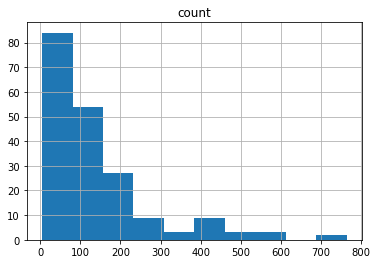

In [57]:
nta_shp_counts[['count']].hist()

<AxesSubplot:>

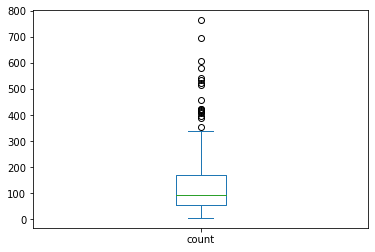

In [58]:
nta_shp_counts[['count']].plot.box()

In [59]:
nta_shp_counts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      194 non-null    object  
 1   shape_area   194 non-null    object  
 2   county_fips  194 non-null    object  
 3   ntaname      194 non-null    object  
 4   shape_leng   194 non-null    object  
 5   boro_name    194 non-null    object  
 6   boro_code    194 non-null    object  
 7   geometry     194 non-null    geometry
 8   count        194 non-null    int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 15.2+ KB


In [60]:
nta_shp_counts['shape_area'] = nta_shp_counts['shape_area'].astype(float)
nta_shp_counts['shape_leng'] = nta_shp_counts['shape_leng'].astype(float)
                                                                          
nta_shp_counts.info()                                                                          

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      194 non-null    object  
 1   shape_area   194 non-null    float64 
 2   county_fips  194 non-null    object  
 3   ntaname      194 non-null    object  
 4   shape_leng   194 non-null    float64 
 5   boro_name    194 non-null    object  
 6   boro_code    194 non-null    object  
 7   geometry     194 non-null    geometry
 8   count        194 non-null    int64   
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 15.2+ KB


In [61]:
square_miles_conversion = 27878400
nta_shp_counts['count_sq_mi'] = (nta_shp_counts['count'] / 
                                ((nta_shp_counts['shape_area'] / square_miles_conversion)))

nta_shp_counts.head() 

ntacode    shape_area county_fips                ntaname    shape_leng  \
0    QN08  7.741275e+07         081             St. Albans  45401.316921   
1    BX28  2.566612e+07         005  Van Cortlandt Village  21945.719299   
2    QN55  8.246139e+07         081       South Ozone Park  36708.169488   
3    BK40  1.404167e+07         047        Windsor Terrace  19033.671810   
4    BK50  8.208968e+07         047               Canarsie  43703.609550   

  boro_name boro_code                                           geometry  \
0    Queens         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...   
1     Bronx         2  MULTIPOLYGON (((1015481.837 261490.578, 101548...   
2    Queens         4  MULTIPOLYGON (((1038120.503 188147.096, 103819...   
3  Brooklyn         3  MULTIPOLYGON (((989751.226 180153.633, 989741....   
4  Brooklyn         3  MULTIPOLYGON (((1015236.151 174910.303, 101523...   

   count  count_sq_mi  
0    581   209.233632  
1     45    48.878747  
2    419   141.654768  
3     55   109.197284  
4    423   143.654640

In [62]:
nta_shp_counts[['count', 'count_sq_mi']].describe()

count  count_sq_mi
count  194.000000   194.000000
mean   138.948454    98.861350
std    135.372399    61.612742
min      5.000000     0.732936
25%     53.000000    59.048759
50%     92.500000    84.149123
75%    169.750000   129.939997
max    763.000000   383.623247

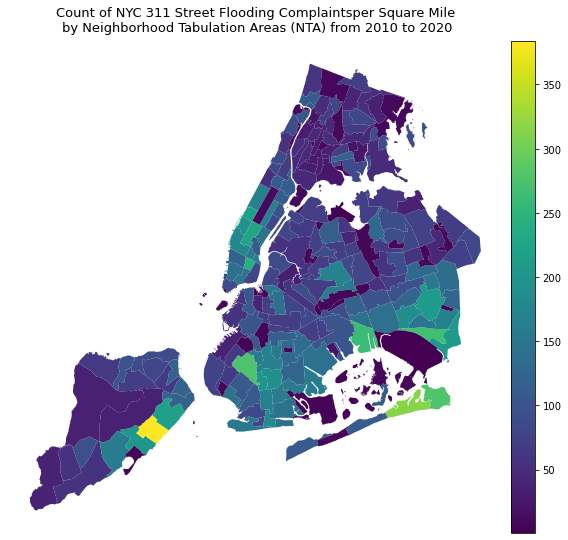

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))

comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

nta_shp_counts.plot(column='count_sq_mi', 
                   cmap='viridis',
                   ax=ax, 
                   legend=True,
                   cax=cax,
                   legend_kwds={'format':comma_fmt})

title = 'Count of NYC 311 Street Flooding Complaints\
per Square Mile\n by Neighborhood Tabulation Areas (NTA) from 2010 to 2020'
ax.set_title(title, 
             fontsize=13, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

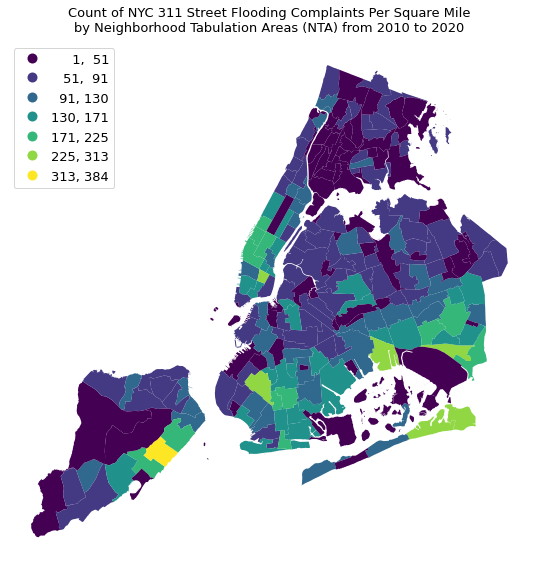

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))

nta_shp_counts.plot(column='count_sq_mi', 
                    cmap='viridis',
                    ax=ax, 
                    legend=True, 
                    scheme='fisher_jenks',
                    k=7,
                    legend_kwds={'loc': "upper left", 
                              'fmt': "{:,.0f}",
                              'fontsize': "13"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(90) 
        row.mode= "expand"
        row.align="right" 

        
title = 'Count of NYC 311 Street Flooding Complaints Per Square Mile\n\
by Neighborhood Tabulation Areas (NTA) from 2010 to 2020'    
ax.set_title(title, fontsize=13, pad=10)

ax.axis('off')
plt.tight_layout()

## print display - looks a big funky in the notebook

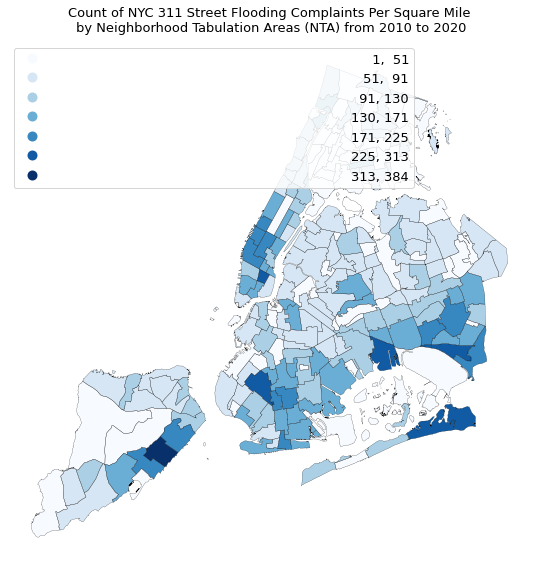

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))

nta_shp_counts.plot(column='count_sq_mi', 
                    cmap='Blues',
                    ax=ax, 
                    legend=True, 
                    scheme='fisher_jenks',
                    k=7,
                    legend_kwds={'loc': "upper left", 
                              'fmt': "{:,.0f}",
                              'fontsize': "13"})

nta_shape.to_crs(2263).plot(facecolor="none", 
                            edgecolor="black", 
                            linewidth=.2,
                            ax=ax)
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(390) 
        row.mode= "expand"
        row.align="right" 

        
title = 'Count of NYC 311 Street Flooding Complaints Per Square Mile\n \
by Neighborhood Tabulation Areas (NTA) from 2010 to 2020'    
ax.set_title(title, fontsize=13, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/cover-photo.png', dpi=300)

# Multiple Subplots

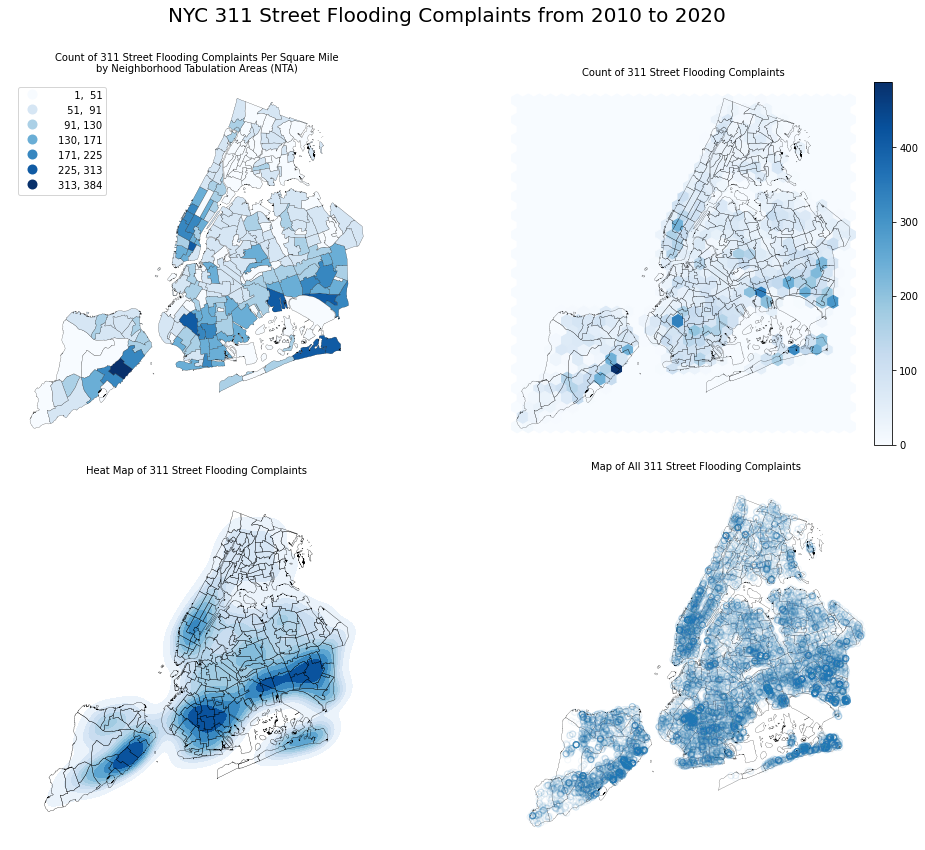

In [66]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(15, 12))

# first Plot
nta_shp_counts.plot(column='count_sq_mi', 
                    cmap='Blues',
                    ax=axs[0,0], 
                    legend=True, 
                    scheme='fisher_jenks',
                    linewidth=.2, 
                    edgecolor='black',
                    k=7,
                    legend_kwds={'loc': "upper left", 
                              'fmt': "{:,.0f}",
                              'fontsize': "10"})

leg = axs[0,0].get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(80)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

axs[0,0].set_title('Count of 311 Street Flooding Complaints Per Square Mile\nby Neighborhood Tabulation Areas (NTA)', 
             fontsize=10, 
             pad=10)
axs[0,0].axis('off')

# second Plot
hb = axs[0,1].hexbin(gdf['x_coordinate_state_plane'], 
                     gdf['y_coordinate_state_plane'], 
                     gridsize=30, 
                     cmap='Blues')

divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.to_crs(2263).plot(facecolor="none", 
                            edgecolor="black", 
                            linewidth=.2,
                            ax=axs[0,1])

axs[0,1].set_title("Count of 311 Street Flooding Complaints", 
             fontsize=10)
axs[0,1].axis('off')

# third plot
sns.kdeplot(data=gdf,
            x='x_coordinate_state_plane',
            y='y_coordinate_state_plane',
            fill=True,
            cmap='Blues',
            ax=axs[1,0])

nta_shape.plot(ax=axs[1,0], 
               color='None', 
               edgecolor='black', 
               zorder=1,
               linewidth=.3)

axs[1,0].set_title("Heat Map of 311 Street Flooding Complaints", 
             fontsize=10)
axs[1,0].set_aspect('equal', 'box')
axs[1,0].axis('off')


# fourth Plot
nta_shape.plot(ax=axs[1,1], 
               color='white', 
               edgecolor='black', 
               linewidth=.2,
               zorder=0)

gdf.plot(ax=axs[1,1], 
         color='None', 
         alpha=.05,
         edgecolor='#1f77b4')

axs[1,1].set_title("Map of All 311 Street Flooding Complaints", 
                   fontsize=10, 
                   pad=10)
axs[1,1].axis('off')

fig.suptitle('NYC 311 Street Flooding Complaints from 2010 to 2020\n', fontsize=20) 
fig.tight_layout()

# Mapping by Year

In [67]:
# make sure same crs
gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [68]:
nta_shape.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [69]:
year_nta = gdf.copy()

year_nta.head()

unique_key        created_date              closed_date agency  \
0    48542220 2020-12-31 15:41:00  2021-01-01T00:20:00.000    DEP   
1    48540279 2020-12-31 09:23:00  2021-01-05T10:15:00.000    DEP   
2    48534652 2020-12-30 17:09:00  2020-12-31T07:02:00.000    DEP   
3    48496821 2020-12-26 16:23:00  2020-12-28T09:45:00.000    DEP   
4    48367735 2020-12-09 12:57:00  2020-12-09T17:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                   NaN  ...      FOCH BLVD        120 AVE  4.116990e+09   
1                   NaN  ...        107 AVE        109 AVE  4.095470e+09   
2                   NaN  ...         124 ST         125 ST  4.116510e+09   
3                   NaN  ...      CEDRIC RD     SUTTER AVE           NaN   
4                   NaN  ...        109 AVE        111 AVE  4.116110e+09   

                         geometry  year ntacode  county_fips  \
0  POINT (1038500.000 186000.000)  2020    QN55          081   
1  POINT (1031154.000 187736.000)  2020    QN55          081   
2  POINT (1035567.000 186465.000)  2020    QN55          081   
3  POINT (1037333.000 184337.000)  2020    QN55          081   
4  POINT (1036537.000 188991.000)  2020    QN55          081   

            ntaname boro_name boro_code  
0  South Ozone Park    Queens         4  
1  South Ozone Park    Queens         4  
2  South Ozone Park    Queens         4  
3  South Ozone Park    Queens         4  
4  South Ozone Park    Queens         4  

[5 rows x 36 columns]

In [70]:
year_nta = (
    year_nta
    .groupby(by=['year', 'ntaname'])['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

year_nta.head()

year                                     ntaname  count
0  2010                     Allerton-Pelham Gardens      3
1  2010  Annadale-Huguenot-Prince's Bay-Eltingville     30
2  2010                               Arden Heights     16
3  2010                                     Astoria      8
4  2010                                  Auburndale     10

In [71]:
year_nta = nta_shape.merge(year_nta, 
                           left_on='ntaname', 
                           right_on='ntaname')

year_nta.head()

ntacode     shape_area county_fips     ntaname     shape_leng boro_name  \
0    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
1    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
2    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
3    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
4    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   

  boro_code                                           geometry  year  count  
0         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2010     52  
1         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2011     57  
2         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2012     70  
3         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2013     56  
4         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2014     41

In [72]:
year_nta['count_sq_mi'] = (year_nta['count'] / (year_nta['shape_area'].astype(float) / 27878400))

year_nta.head()

ntacode     shape_area county_fips     ntaname     shape_leng boro_name  \
0    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
1    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
2    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
3    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   
4    QN08  77412747.7931         081  St. Albans  45401.3169214    Queens   

  boro_code                                           geometry  year  count  \
0         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2010     52   
1         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2011     57   
2         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2012     70   
3         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2013     56   
4         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...  2014     41   

   count_sq_mi  
0    18.726590  
1    20.527224  
2    25.208871  
3    20.167097  
4    14.765196

In [73]:
# preview year loop
years = list(year_nta.year.unique())

print(type(years))
for year in years:
    print(year)

<class 'list'>
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


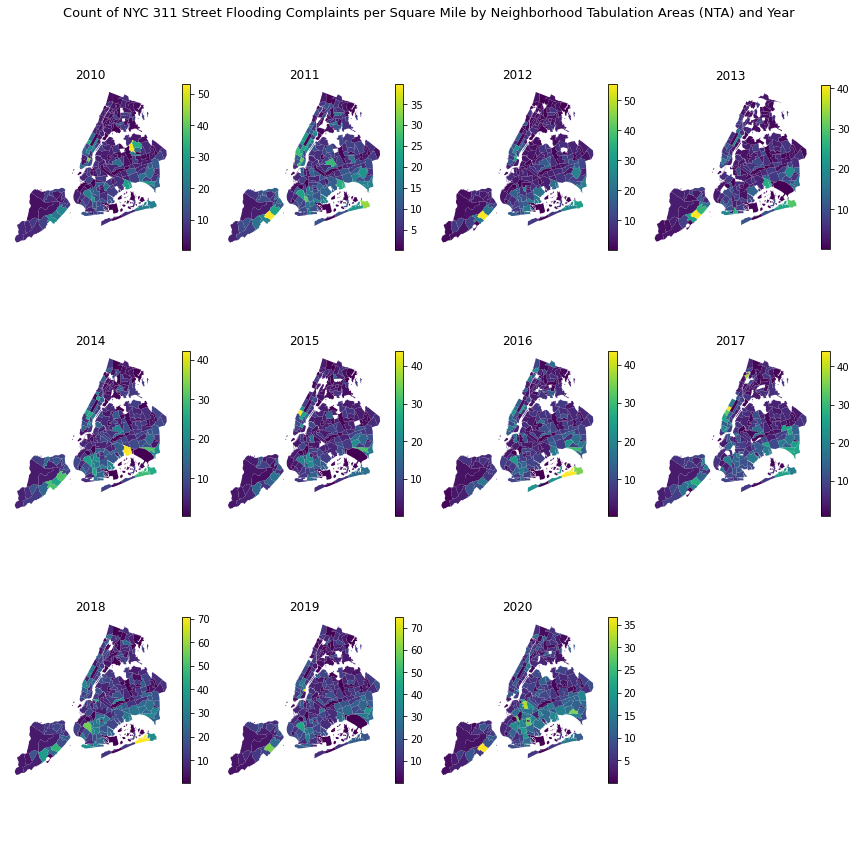

In [74]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax, year in zip(axes.flat, years):
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    year_nta.loc[year_nta['year'] == year].plot(column='count_sq_mi', 
                                                cmap='viridis',
                                                legend=True,
                                                ax=ax, 
                                                cax=cax)

    ax.set_title(str(year), fontsize=12)
    ax.axis('off')

axes[2,3].set_axis_off()

fig.suptitle('Count of NYC 311 Street Flooding Complaints per Square Mile \
by Neighborhood Tabulation Areas (NTA) and Year', fontsize=13) 
fig.tight_layout()   

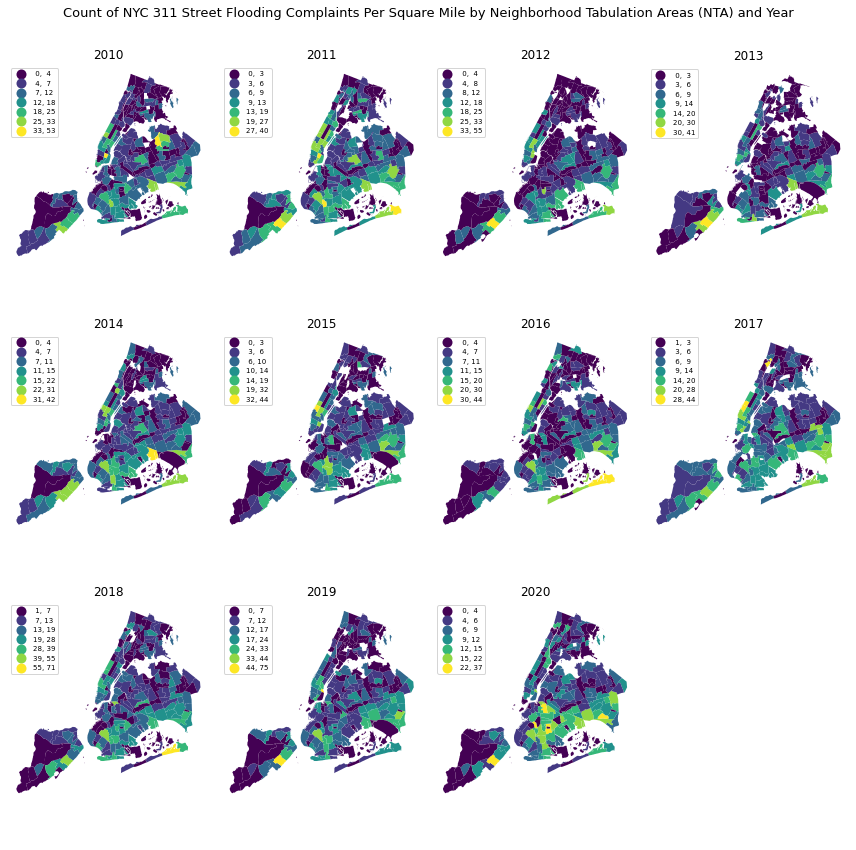

In [75]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax, year in zip(axes.flat, years):
    year_nta.loc[year_nta['year'] == year].plot(column='count_sq_mi', 
                                              cmap='viridis',
                                              legend=True, 
                                              figsize=(6,6),
                                              scheme='fisher_jenks',
                                              k=7,
                                              legend_kwds={'loc': "upper left", 
                                                           'fmt': "{:,.0f}",
                                                           'fontsize': "7"},
                                              ax=ax)

    
    ax.set_title(str(year), fontsize=12)
    ax.axis('off')

axes[2,3].set_axis_off()   

fig.suptitle('Count of NYC 311 Street Flooding Complaints Per Square Mile \
by Neighborhood Tabulation Areas (NTA) and Year', fontsize=13)
fig.tight_layout()

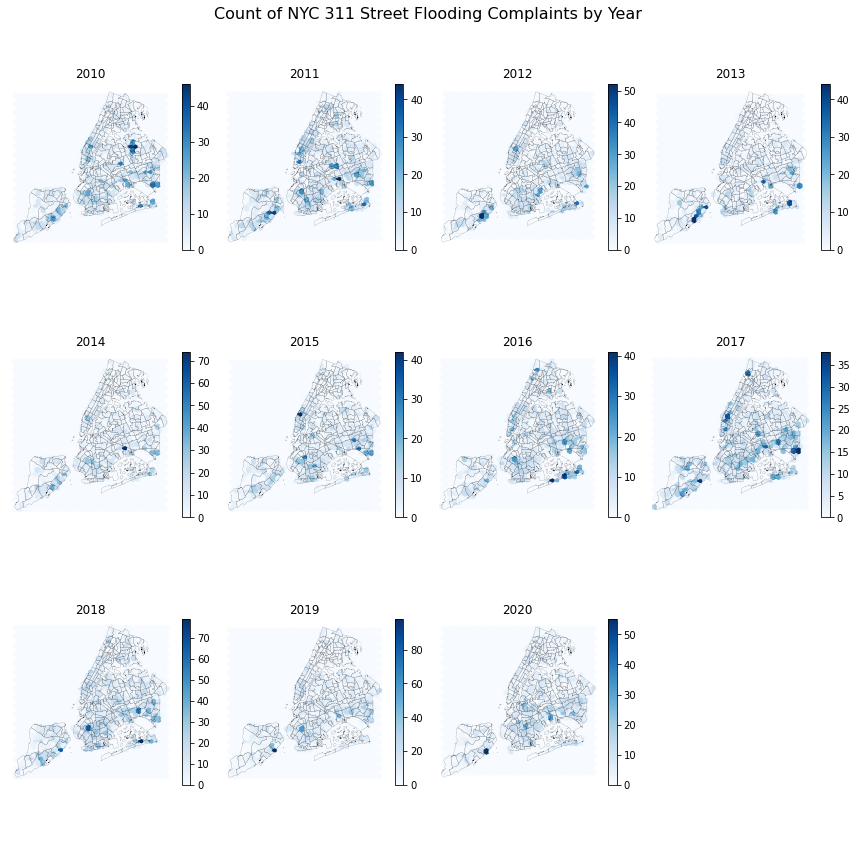

In [76]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax, year in zip(axes.flat, years):
    
    df = gdf.loc[gdf['year'] == year]
    hb = ax.hexbin(df.x_coordinate_state_plane, 
                   df.y_coordinate_state_plane, 
                   gridsize=30, 
                   cmap='Blues')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(hb, cax=cax)

    nta_shape.plot(facecolor="none", 
                   edgecolor="black", 
                   ax=ax,
                   zorder=1,
                   linewidth=.1)
 
    ax.set_title(str(year), fontsize=12)
    ax.axis('off')

axes[2,3].set_axis_off()   

fig.suptitle('Count of NYC 311 Street Flooding Complaints by Year', fontsize=16) 
fig.tight_layout()    

## 5.2 By Borough

In [77]:
gdf.head()

unique_key        created_date              closed_date agency  \
0    48542220 2020-12-31 15:41:00  2021-01-01T00:20:00.000    DEP   
1    48540279 2020-12-31 09:23:00  2021-01-05T10:15:00.000    DEP   
2    48534652 2020-12-30 17:09:00  2020-12-31T07:02:00.000    DEP   
3    48496821 2020-12-26 16:23:00  2020-12-28T09:45:00.000    DEP   
4    48367735 2020-12-09 12:57:00  2020-12-09T17:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                   NaN  ...      FOCH BLVD        120 AVE  4.116990e+09   
1                   NaN  ...        107 AVE        109 AVE  4.095470e+09   
2                   NaN  ...         124 ST         125 ST  4.116510e+09   
3                   NaN  ...      CEDRIC RD     SUTTER AVE           NaN   
4                   NaN  ...        109 AVE        111 AVE  4.116110e+09   

                         geometry  year ntacode  county_fips  \
0  POINT (1038500.000 186000.000)  2020    QN55          081   
1  POINT (1031154.000 187736.000)  2020    QN55          081   
2  POINT (1035567.000 186465.000)  2020    QN55          081   
3  POINT (1037333.000 184337.000)  2020    QN55          081   
4  POINT (1036537.000 188991.000)  2020    QN55          081   

            ntaname boro_name boro_code  
0  South Ozone Park    Queens         4  
1  South Ozone Park    Queens         4  
2  South Ozone Park    Queens         4  
3  South Ozone Park    Queens         4  
4  South Ozone Park    Queens         4  

[5 rows x 36 columns]

In [78]:
gdf['boro_name'].value_counts()

Queens           10631
Brooklyn          6946
Staten Island     4928
Manhattan         2552
Bronx             1899
Name: boro_name, dtype: int64

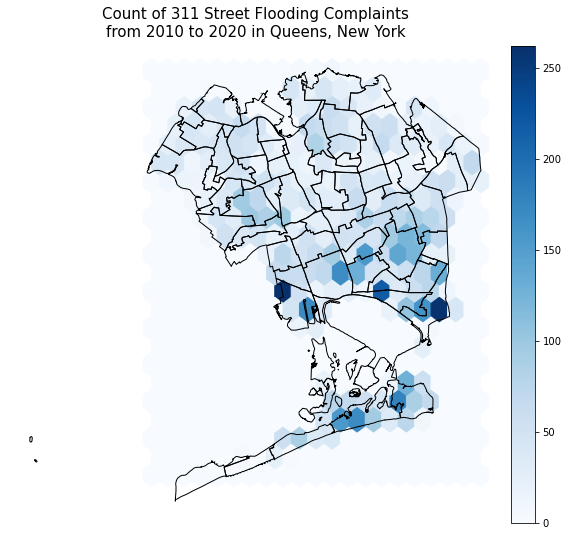

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf[gdf['boro_name'] == 'Queens']['x_coordinate_state_plane'], 
               gdf[gdf['boro_name'] == 'Queens']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Queens'].plot(facecolor="none", 
                                                edgecolor="black", 
                                                ax=ax)


ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in Queens, New York', fontsize=15, pad=10)
plt.tight_layout()

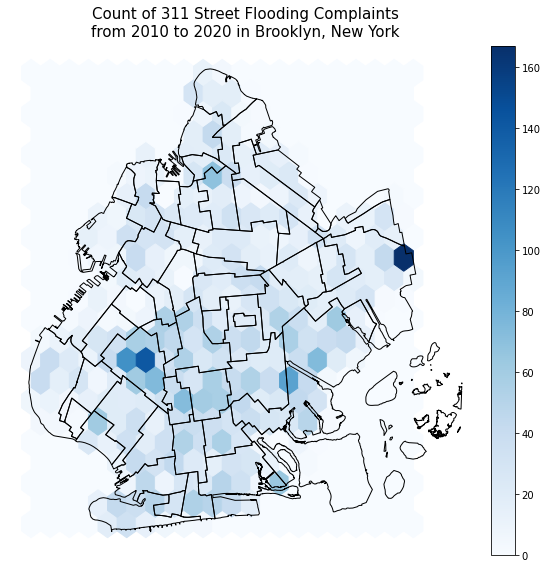

In [80]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf[gdf['boro_name'] == 'Brooklyn']['x_coordinate_state_plane'], 
               gdf[gdf['boro_name'] == 'Brooklyn']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Brooklyn'].plot(facecolor="none", 
                                                  edgecolor="black", 
                                                  ax=ax)

ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 \
in Brooklyn, New York', fontsize=15, pad=10)
plt.tight_layout()

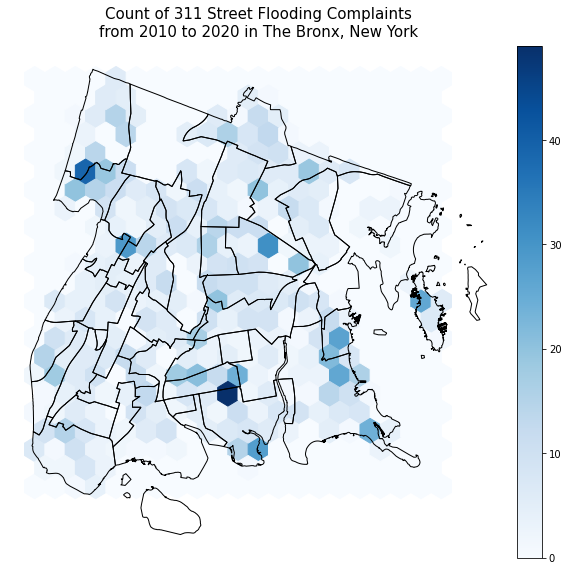

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf[gdf['boro_name'] == 'Bronx']['x_coordinate_state_plane'], 
               gdf[gdf['boro_name'] == 'Bronx']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Bronx'].plot(facecolor="none", 
                                               edgecolor="black", 
                                               ax=ax)

ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in The Bronx, New York', fontsize=15, pad=10)
plt.tight_layout()

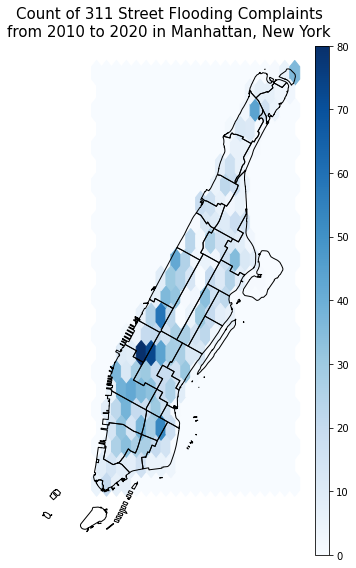

In [82]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf[gdf['boro_name'] == 'Manhattan']['x_coordinate_state_plane'], 
               gdf[gdf['boro_name'] == 'Manhattan']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Manhattan'].plot(facecolor="none", 
                                                   edgecolor="black", 
                                                   ax=ax)

ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in Manhattan, New York', fontsize=15, pad=10)
plt.tight_layout()

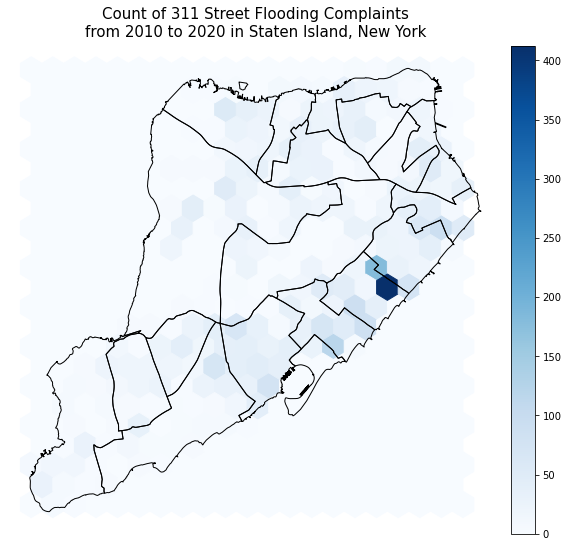

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf[gdf['boro_name'] == 'Staten Island']['x_coordinate_state_plane'], 
               gdf[gdf['boro_name'] == 'Staten Island']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Staten Island'].plot(facecolor="none", 
                                                       edgecolor="black", 
                                                       ax=ax)
ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in Staten Island, New York', fontsize=15, pad=10)
plt.tight_layout()

In [84]:
# retrieve list of boros
boroughs = gdf['boro_name'].unique()

boroughs

array(['Queens', 'Brooklyn', 'Manhattan', 'Staten Island', 'Bronx'],
      dtype=object)

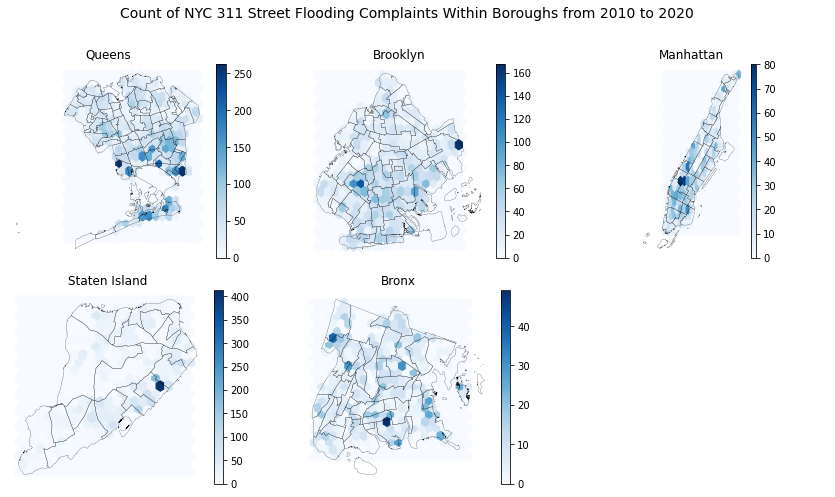

In [85]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

for ax, borough in zip(axes.flat, boroughs):

    hb = ax.hexbin(gdf[gdf['boro_name'] == borough]['x_coordinate_state_plane'], 
                   gdf[gdf['boro_name'] == borough]['y_coordinate_state_plane'], 
                   gridsize=20, 
                   cmap='Blues')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(hb, cax=cax)

    nta_shape[nta_shape.boro_name == borough.title()].plot(facecolor="none", 
                                                           edgecolor="black", 
                                                           linewidth=.2,
                                                           ax=ax)
    ax.set_title(borough.title())
    ax.axis('off')   

axes[1,2].set_axis_off() 
fig.suptitle("Count of NYC 311 Street Flooding Complaints \
Within Boroughs from 2010 to 2020\n", fontsize=14)
fig.tight_layout()

## 5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)

In [86]:
nta_shp_counts.sort_values(by='count_sq_mi', ascending=False).head(10)

ntacode    shape_area county_fips                               ntaname  \
146    SI45  5.544820e+07         085                New Dorp-Midland Beach   
59     QN12  6.189991e+07         081              Hammels-Arverne-Edgemere   
39     QN15  5.420674e+07         081                Far Rockaway-Bayswater   
113    BK88  5.400495e+07         047                          Borough Park   
10     QN03  4.328746e+07         081  Springfield Gardens South-Brookville   
121    QN57  6.454397e+07         081               Lindenwood-Howard Beach   
155    MN22  1.089424e+07         061                          East Village   
180    MN17  3.019128e+07         061                 Midtown-Midtown South   
116    MN14  1.580591e+07         061                        Lincoln Square   
148    SI36  6.701198e+07         085     Old Town-Dongan Hills-South Beach   

       shape_leng      boro_name boro_code  \
146  34369.889446  Staten Island         5   
59   83078.816598         Queens         4   
39   48666.028615         Queens         4   
113  39247.239969       Brooklyn         3   
10   45320.258364         Queens         4   
121  79069.234751         Queens         4   
155  13555.231504      Manhattan         1   
180  27032.730332      Manhattan         1   
116  19871.831349      Manhattan         1   
148  41972.446769  Staten Island         5   

                                              geometry  count  count_sq_mi  
146  MULTIPOLYGON (((960721.678 147492.705, 960370....    763   383.623247  
59   MULTIPOLYGON (((1048650.179 157173.329, 104869...    696   313.463541  
39   MULTIPOLYGON (((1049860.888 154842.594, 104983...    541   278.235042  
113  MULTIPOLYGON (((990897.911 169268.253, 990588....    535   276.177364  
10   MULTIPOLYGON (((1051488.015 182175.831, 105150...    415   267.272251  
121  MULTIPOLYGON (((1023868.796 176222.945, 102336...    605   261.316936  
155  MULTIPOLYGON (((989084.477 205727.827, 989108....     94   240.546289  
180  MULTIPOLYGON (((991725.183 217725.502, 992169....    244   225.307776  
116  MULTIPOLYGON (((991173.587 222552.343, 991046....    124   218.710632  
148  MULTIPOLYGON (((966187.529 153868.497, 966187....    523   217.579062

In [87]:
nta_shp_counts['nta_borough'] = nta_shp_counts['ntaname'] + ' - ' + nta_shp_counts['boro_name']

nta_shp_counts.head()

ntacode    shape_area county_fips                ntaname    shape_leng  \
0    QN08  7.741275e+07         081             St. Albans  45401.316921   
1    BX28  2.566612e+07         005  Van Cortlandt Village  21945.719299   
2    QN55  8.246139e+07         081       South Ozone Park  36708.169488   
3    BK40  1.404167e+07         047        Windsor Terrace  19033.671810   
4    BK50  8.208968e+07         047               Canarsie  43703.609550   

  boro_name boro_code                                           geometry  \
0    Queens         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...   
1     Bronx         2  MULTIPOLYGON (((1015481.837 261490.578, 101548...   
2    Queens         4  MULTIPOLYGON (((1038120.503 188147.096, 103819...   
3  Brooklyn         3  MULTIPOLYGON (((989751.226 180153.633, 989741....   
4  Brooklyn         3  MULTIPOLYGON (((1015236.151 174910.303, 101523...   

   count  count_sq_mi                    nta_borough  
0    581   209.233632            St. Albans - Queens  
1     45    48.878747  Van Cortlandt Village - Bronx  
2    419   141.654768      South Ozone Park - Queens  
3     55   109.197284     Windsor Terrace - Brooklyn  
4    423   143.654640            Canarsie - Brooklyn

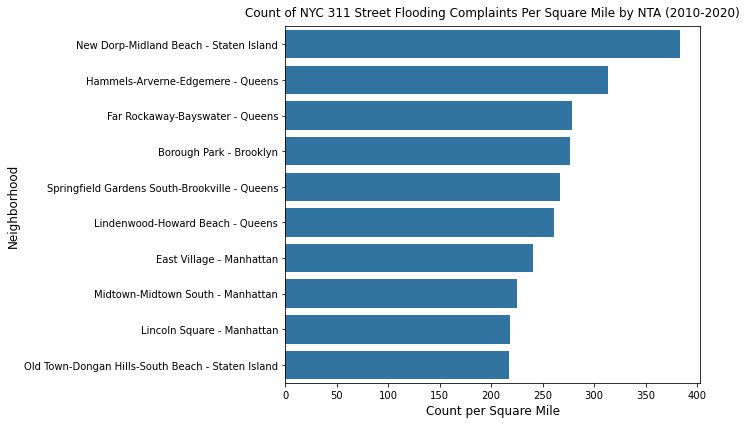

In [88]:
plt.figure(figsize=(10,6))

sns.barplot(data=nta_shp_counts.sort_values(by='count_sq_mi', ascending=False).head(10),
            y='nta_borough',
            x='count_sq_mi',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints Per Square Mile by NTA (2010-2020)', 
          fontsize=12,
          pad=10)
plt.xlabel('Count per Square Mile', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.tight_layout()

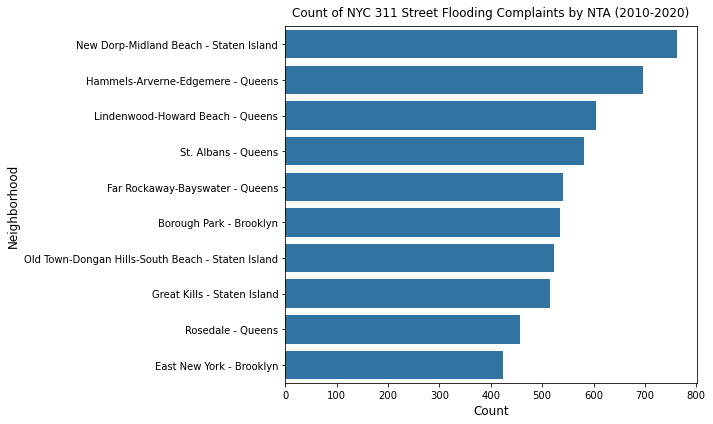

In [89]:
plt.figure(figsize=(10,6))

sns.barplot(data=nta_shp_counts.sort_values(by='count', ascending=False).head(10),
            y='nta_borough',
            x='count',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by NTA (2010-2020)', 
          fontsize=12,
          pad=10)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.tight_layout()

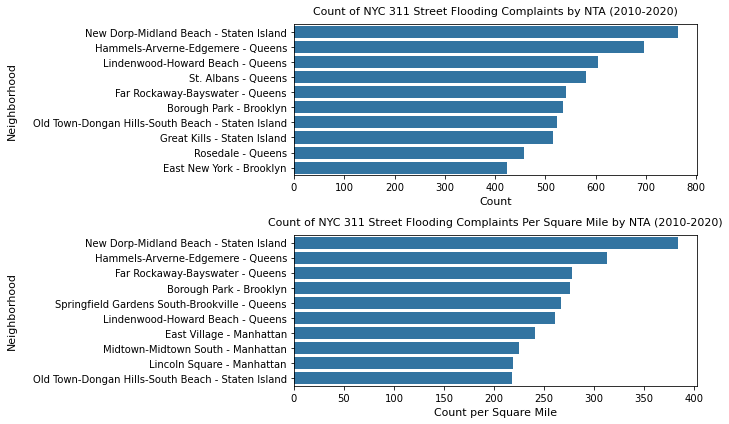

In [90]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(10, 6))

# first plot
sns.barplot(data=nta_shp_counts.sort_values(by='count', ascending=False).head(10),
            y='nta_borough',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by NTA (2010-2020)', 
          fontsize=11,
          pad=10)
axs[0].set_xlabel('Count', fontsize=11)
axs[0].set_ylabel('Neighborhood\n', fontsize=11)

# second plot
sns.barplot(data=nta_shp_counts.sort_values(by='count_sq_mi', ascending=False).head(10),
            y='nta_borough',
            x='count_sq_mi',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints Per Square Mile by NTA (2010-2020)', 
          fontsize=11,
          pad=10)
axs[1].set_xlabel('Count per Square Mile', fontsize=11)
axs[1].set_ylabel('Neighborhood\n', fontsize=11)

plt.tight_layout()

# 6. Timedelta of Complaints Response Time

In [91]:
gdf.head()

unique_key        created_date              closed_date agency  \
0    48542220 2020-12-31 15:41:00  2021-01-01T00:20:00.000    DEP   
1    48540279 2020-12-31 09:23:00  2021-01-05T10:15:00.000    DEP   
2    48534652 2020-12-30 17:09:00  2020-12-31T07:02:00.000    DEP   
3    48496821 2020-12-26 16:23:00  2020-12-28T09:45:00.000    DEP   
4    48367735 2020-12-09 12:57:00  2020-12-09T17:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                   NaN  ...      FOCH BLVD        120 AVE  4.116990e+09   
1                   NaN  ...        107 AVE        109 AVE  4.095470e+09   
2                   NaN  ...         124 ST         125 ST  4.116510e+09   
3                   NaN  ...      CEDRIC RD     SUTTER AVE           NaN   
4                   NaN  ...        109 AVE        111 AVE  4.116110e+09   

                         geometry  year ntacode  county_fips  \
0  POINT (1038500.000 186000.000)  2020    QN55          081   
1  POINT (1031154.000 187736.000)  2020    QN55          081   
2  POINT (1035567.000 186465.000)  2020    QN55          081   
3  POINT (1037333.000 184337.000)  2020    QN55          081   
4  POINT (1036537.000 188991.000)  2020    QN55          081   

            ntaname boro_name boro_code  
0  South Ozone Park    Queens         4  
1  South Ozone Park    Queens         4  
2  South Ozone Park    Queens         4  
3  South Ozone Park    Queens         4  
4  South Ozone Park    Queens         4  

[5 rows x 36 columns]

In [92]:
gdf['closed_date'] = pd.to_datetime(gdf['closed_date'])

gdf.head()

unique_key        created_date         closed_date agency  \
0    48542220 2020-12-31 15:41:00 2021-01-01 00:20:00    DEP   
1    48540279 2020-12-31 09:23:00 2021-01-05 10:15:00    DEP   
2    48534652 2020-12-30 17:09:00 2020-12-31 07:02:00    DEP   
3    48496821 2020-12-26 16:23:00 2020-12-28 09:45:00    DEP   
4    48367735 2020-12-09 12:57:00 2020-12-09 17:55:00    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
0                   NaN  ...      FOCH BLVD        120 AVE  4.116990e+09   
1                   NaN  ...        107 AVE        109 AVE  4.095470e+09   
2                   NaN  ...         124 ST         125 ST  4.116510e+09   
3                   NaN  ...      CEDRIC RD     SUTTER AVE           NaN   
4                   NaN  ...        109 AVE        111 AVE  4.116110e+09   

                         geometry  year ntacode  county_fips  \
0  POINT (1038500.000 186000.000)  2020    QN55          081   
1  POINT (1031154.000 187736.000)  2020    QN55          081   
2  POINT (1035567.000 186465.000)  2020    QN55          081   
3  POINT (1037333.000 184337.000)  2020    QN55          081   
4  POINT (1036537.000 188991.000)  2020    QN55          081   

            ntaname boro_name boro_code  
0  South Ozone Park    Queens         4  
1  South Ozone Park    Queens         4  
2  South Ozone Park    Queens         4  
3  South Ozone Park    Queens         4  
4  South Ozone Park    Queens         4  

[5 rows x 36 columns]

In [93]:
gdf.iloc[:, :3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26956 entries, 0 to 26955
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   unique_key    26956 non-null  int64         
 1   created_date  26956 non-null  datetime64[ns]
 2   closed_date   26954 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 631.9 KB


In [94]:
gdf['complaint_duration'] = gdf['closed_date'] - gdf['created_date']

gdf[['created_date', 'closed_date', 'complaint_duration']].head(10)

created_date         closed_date complaint_duration
0 2020-12-31 15:41:00 2021-01-01 00:20:00    0 days 08:39:00
1 2020-12-31 09:23:00 2021-01-05 10:15:00    5 days 00:52:00
2 2020-12-30 17:09:00 2020-12-31 07:02:00    0 days 13:53:00
3 2020-12-26 16:23:00 2020-12-28 09:45:00    1 days 17:22:00
4 2020-12-09 12:57:00 2020-12-09 17:55:00    0 days 04:58:00
5 2020-11-30 14:22:00 2020-12-01 09:10:00    0 days 18:48:00
6 2020-11-23 08:58:00 2020-11-24 10:10:00    1 days 01:12:00
7 2020-11-12 04:39:00 2020-11-12 05:05:00    0 days 00:26:00
8 2020-11-01 23:58:00 2020-11-03 10:00:00    1 days 10:02:00
9 2020-10-21 14:34:00 2020-10-24 10:35:00    2 days 20:01:00

In [95]:
gdf[['created_date', 'closed_date', 'complaint_duration']].tail(10)

created_date         closed_date complaint_duration
26946 2018-03-12 11:01:00 2018-03-13 13:40:00    1 days 02:39:00
26947 2015-06-01 08:07:00 2015-06-02 09:20:00    1 days 01:13:00
26948 2014-05-01 09:08:00 2014-05-01 10:20:00    0 days 01:12:00
26949 2012-05-21 09:53:00 2012-05-21 10:45:00    0 days 00:52:00
26950 2011-12-18 16:47:00 2011-12-19 09:30:00    0 days 16:43:00
26951 2018-04-16 10:53:00 2018-04-17 15:58:00    1 days 05:05:00
26952 2018-04-16 09:00:00 2018-04-16 11:15:00    0 days 02:15:00
26953 2017-10-29 22:15:00 2017-10-30 08:30:00    0 days 10:15:00
26954 2013-06-15 21:30:00 2013-06-17 10:00:00    1 days 12:30:00
26955 2012-10-09 17:14:00 2012-10-10 10:30:00    0 days 17:16:00

In [96]:
gdf[['complaint_duration']].describe()

complaint_duration
count                       26954
mean    2 days 12:35:42.412257920
std    12 days 22:17:11.411529540
min           -435 days +08:49:00
25%               0 days 03:04:00
50%               0 days 17:19:00
75%               1 days 18:46:45
max             569 days 16:46:00

In [97]:
(gdf
 .sort_values(by='complaint_duration', ascending=True)
 .loc[:, ['created_date', 'closed_date', 'complaint_duration']]
 .head()
)

created_date         closed_date  complaint_duration
5329  2020-12-28 15:30:00 2019-10-21 00:19:00 -435 days +08:49:00
5338  2020-12-28 13:45:00 2020-01-16 13:07:00 -348 days +23:22:00
3926  2020-12-29 16:19:00 2020-07-31 02:31:00 -152 days +10:12:00
9924  2020-08-12 16:39:00 2020-08-03 09:20:00  -10 days +16:41:00
20213 2020-03-25 10:52:00 2020-03-20 08:45:00   -6 days +21:53:00

In [98]:
(gdf
 .sort_values(by='complaint_duration', ascending=False)
 .loc[:, ['created_date', 'closed_date', 'complaint_duration']]
 .head()
)

created_date         closed_date complaint_duration
19050 2019-01-20 18:14:00 2020-08-12 11:00:00  569 days 16:46:00
26133 2018-11-16 15:30:00 2020-03-19 11:20:00  488 days 19:50:00
4985  2019-01-11 12:45:00 2020-02-23 13:30:00  408 days 00:45:00
5100  2016-07-25 17:46:00 2017-07-31 09:30:00  370 days 15:44:00
16049 2015-06-28 06:41:00 2016-06-29 10:10:00  367 days 03:29:00

In [99]:
gdf['complaint_duration_days'] = gdf['complaint_duration'].dt.days
gdf['complaint_duration_seconds'] = gdf['complaint_duration'].dt.seconds
gdf['complaint_duration_hours'] = gdf['complaint_duration_days'] * 24 + gdf['complaint_duration_seconds'] / 3600

gdf.head()

unique_key        created_date         closed_date agency  \
0    48542220 2020-12-31 15:41:00 2021-01-01 00:20:00    DEP   
1    48540279 2020-12-31 09:23:00 2021-01-05 10:15:00    DEP   
2    48534652 2020-12-30 17:09:00 2020-12-31 07:02:00    DEP   
3    48496821 2020-12-26 16:23:00 2020-12-28 09:45:00    DEP   
4    48367735 2020-12-09 12:57:00 2020-12-09 17:55:00    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11420.0                   NaN   
1  Street Flooding (SJ)       11419.0                   NaN   
2  Street Flooding (SJ)       11420.0                   NaN   
3  Street Flooding (SJ)       11420.0                   NaN   
4  Street Flooding (SJ)       11420.0                   NaN   

  intersection_street_2  ...  year ntacode county_fips           ntaname  \
0                   NaN  ...  2020    QN55         081  South Ozone Park   
1                   NaN  ...  2020    QN55         081  South Ozone Park   
2                   NaN  ...  2020    QN55         081  South Ozone Park   
3                   NaN  ...  2020    QN55         081  South Ozone Park   
4                   NaN  ...  2020    QN55         081  South Ozone Park   

  boro_name boro_code  complaint_duration  complaint_duration_days  \
0    Queens         4     0 days 08:39:00                      0.0   
1    Queens         4     5 days 00:52:00                      5.0   
2    Queens         4     0 days 13:53:00                      0.0   
3    Queens         4     1 days 17:22:00                      1.0   
4    Queens         4     0 days 04:58:00                      0.0   

  complaint_duration_seconds complaint_duration_hours  
0                    31140.0                 8.650000  
1                     3120.0               120.866667  
2                    49980.0                13.883333  
3                    62520.0                41.366667  
4                    17880.0                 4.966667  

[5 rows x 40 columns]

In [100]:
gdf[['complaint_duration_days', 'complaint_duration_hours']].describe()

complaint_duration_days  complaint_duration_hours
count             26954.000000              26954.000000
mean                  2.110596                 60.595115
std                  12.904697                310.286503
min                -435.000000             -10431.183333
25%                   0.000000                  3.066667
50%                   0.000000                 17.316667
75%                   1.000000                 42.779167
max                 569.000000              13672.766667

In [101]:
gdf = gdf.loc[gdf['complaint_duration_days'] > 0].reset_index()

gdf[['complaint_duration_days', 'complaint_duration_hours']].describe()

complaint_duration_days  complaint_duration_hours
count              9438.000000               9438.000000
mean                  6.128947                159.078216
std                  20.382259                489.492315
min                   1.000000                 24.000000
25%                   1.000000                 40.950000
50%                   2.000000                 65.541667
75%                   5.000000                120.000000
max                 569.000000              13672.766667

In [102]:
grouped_gdf = (
    gdf
    .groupby('ntaname')
    .agg({'complaint_duration_hours': ['mean', 'median']})
    .reset_index()
)

grouped_gdf.head()

ntaname complaint_duration_hours  \
                                                                  mean   
0                                     Airport               224.725000   
1                     Allerton-Pelham Gardens                56.047619   
2  Annadale-Huguenot-Prince's Bay-Eltingville                93.278268   
3                               Arden Heights                62.967692   
4                                     Astoria               477.561310   

               
       median  
0  224.725000  
1   46.550000  
2   49.583333  
3   46.383333  
4  109.866667

In [103]:
grouped_gdf.columns = ['ntaname', 'hours_mean', 'hours_median']
grouped_gdf['hours_mean'] = round(grouped_gdf['hours_mean'], 0)
grouped_gdf['hours_median'] = round(grouped_gdf['hours_median'], 0)

grouped_gdf.head()

ntaname  hours_mean  hours_median
0                                     Airport       225.0         225.0
1                     Allerton-Pelham Gardens        56.0          47.0
2  Annadale-Huguenot-Prince's Bay-Eltingville        93.0          50.0
3                               Arden Heights        63.0          46.0
4                                     Astoria       478.0         110.0

<AxesSubplot:>

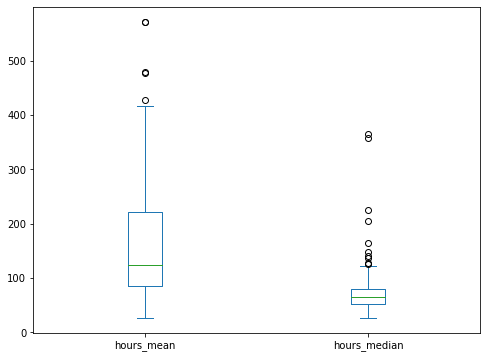

In [104]:
fig, ax = plt.subplots(figsize=(8, 6))

grouped_gdf.iloc[:, 1:].plot.box(ax=ax)

In [105]:
nta_shape_time = nta_shape.merge(grouped_gdf, 
                                 left_on='ntaname', 
                                 right_on='ntaname')

nta_shape_time.head()

ntacode     shape_area county_fips                ntaname     shape_leng  \
0    QN08  77412747.7931         081             St. Albans  45401.3169214   
1    BX28  25666124.5948         005  Van Cortlandt Village   21945.719299   
2    QN55  82461393.7722         081       South Ozone Park   36708.169488   
3    BK40  14041667.9508         047        Windsor Terrace  19033.6718103   
4    BK50  82089678.5909         047               Canarsie  43703.6095503   

  boro_name boro_code                                           geometry  \
0    Queens         4  MULTIPOLYGON (((1052996.196 196307.658, 105308...   
1     Bronx         2  MULTIPOLYGON (((1015481.837 261490.578, 101548...   
2    Queens         4  MULTIPOLYGON (((1038120.503 188147.096, 103819...   
3  Brooklyn         3  MULTIPOLYGON (((989751.226 180153.633, 989741....   
4  Brooklyn         3  MULTIPOLYGON (((1015236.151 174910.303, 101523...   

   hours_mean  hours_median  
0       240.0          58.0  
1       301.0         357.0  
2       182.0          76.0  
3        64.0          46.0  
4       113.0          71.0

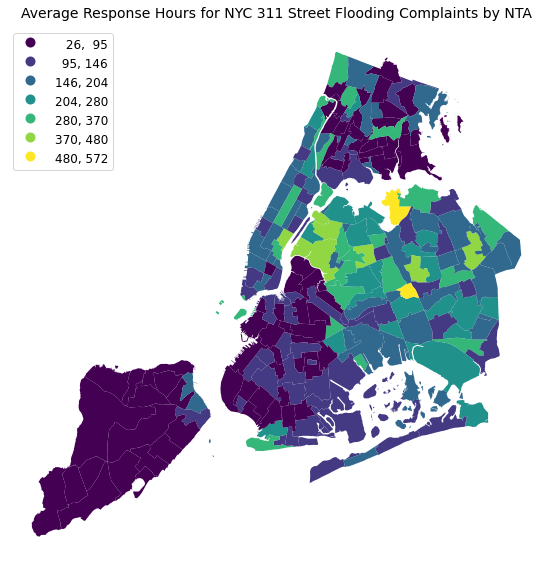

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))

nta_shape_time.plot(column=('hours_mean'), 
                    cmap='viridis',
                    ax=ax, 
                    legend=True, 
                    scheme='fisher_jenks',
                    k=7,
                    legend_kwds={'loc': "upper left", 
                              'fmt': "{:,.0f}",
                              'fontsize': "12"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(90)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

ax.set_title('Average Response Hours for NYC 311 Street Flooding Complaints by NTA', 
             fontsize=14, 
             pad=10)

ax.axis('off')
plt.tight_layout()

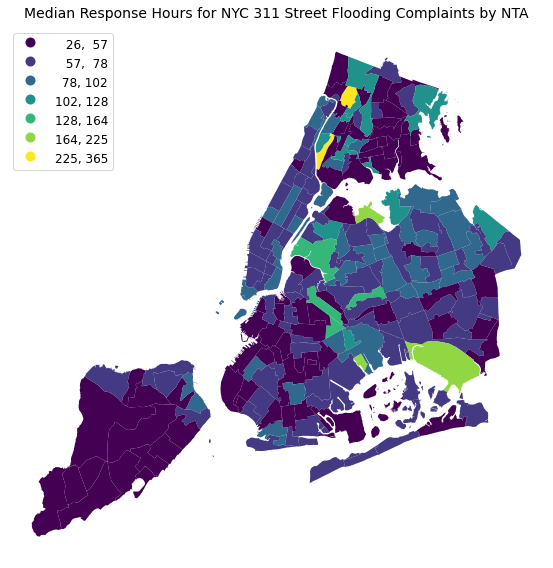

In [107]:
fig, ax = plt.subplots(figsize=(8, 8))

nta_shape_time.plot(column=('hours_median'), 
                    cmap='viridis',
                    ax=ax, 
                    legend=True, 
                    scheme='fisher_jenks',
                    k=7,
                    legend_kwds={'loc': "upper left", 
                              'fmt': "{:,.0f}",
                              'fontsize': "12"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(90)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

ax.set_title('Median Response Hours for NYC 311 Street Flooding Complaints by NTA', 
             fontsize=14, 
             pad=10)

ax.axis('off')
plt.tight_layout()

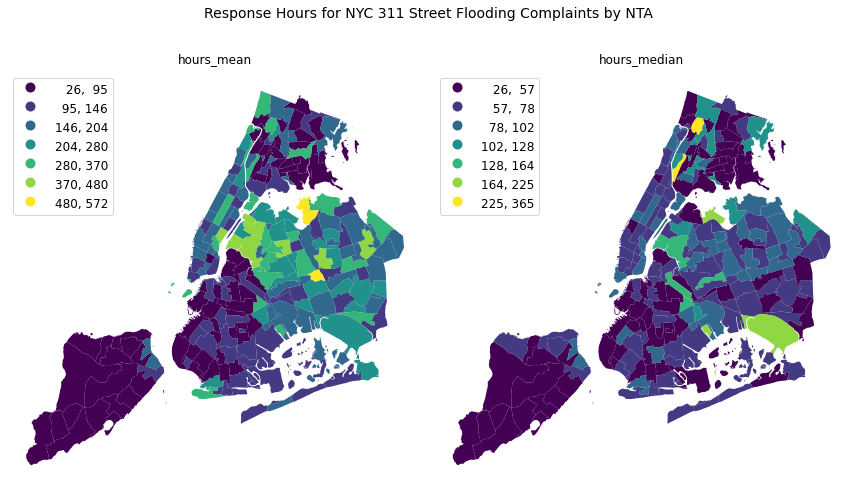

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

cols = ['hours_mean', 'hours_median']

for ax, col in zip(axs, cols):
    
    nta_shape_time.plot(column=col, 
                        cmap='viridis',
                        ax=ax, 
                        legend=True, 
                        scheme='fisher_jenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                  'fmt': "{:,.0f}",
                                  'fontsize': "12"})
    leg = ax.get_legend()

    hp = leg._legend_box.get_children()[1]
    for vp in hp.get_children():
        for row in vp.get_children():
            row.set_width(90)  # need to adapt this manually
            row.mode= "expand"
            row.align="right" 

    ax.set_title(col, 
                 fontsize=12, 
                 pad=10)

    ax.axis('off')

plt.suptitle('Response Hours for NYC 311 \
Street Flooding Complaints by NTA', fontsize=14, y=.80)    
plt.tight_layout()